# TP2: Planificación de Conexión de Oficinas de Atención a Internet

Integrantes: Micaela Oliva, Camila Bernardez, Sol Valeggia, Juan Castore

## Contexto
Estamos en el área de planificación de una empresa de cobros minoristas, y tenemos la responsabilidad de conectar a Internet 56 oficinas de atención al cliente, distribuidas en el micro y macrocentro de la ciudad. La empresa de telefonía nos ha propuesto hasta 10 centrales operativas que pueden ser utilizadas para abastecer estas oficinas.


### 1. Modelo de Programación Lineal Entera

Planteamos el siguiente modelo para resolver la función objetivo, que consiste en minimizar el costo total de operación, decidiendo que centrales utilizar y con qué oficinas conectarlas, sujeto a ciertas restricciones:

  - **Índices**
    - $\mathbb{I} = \{1, \dots, 56\}$: Conjunto de oficinas.
    - $\mathbb{J} = \{1, \dots, 10\}$: Conjunto de centrales operativas.

  - **Parámetros**
    - $\mathrm{dist}_{ij}$: Distancia entre oficina $i$ y central $j$ $\text{ } \text{ } \forall i \in \mathbb{I}, \forall j \in \mathbb{J}$
    - $\mathrm{f} = 5700 \text{ } \mathrm{USD}$: costo fijo por abrir una central.
    - $\mathrm{demanda}_i$: Demanda de operaciones por hora de oficina $i$.
    - $\mathrm{capacidad}_j = 15000$: Capacidad máxima de operaciones por hora que puede atender la central $j$.
    - $cable = 0.017 \text{ } \mathrm{USD/m}$: Costo por metro de cable.

  - **Variables de Decisión**: 
     - $x_{ij}$: Variable binaria que indica si la oficina $i$ está conectada a la central $j$.
     - $y_j$: Variable binaria que indica si la central $j$ está en operación.

En base a lo definido anteriormente, la **función objetivo** a minimizar está dada por:

$$\mathrm{min} \sum_{j \in \mathbb{J}} f \cdot y_j \text{ } + \text{ } \sum_{i \in \mathbb{I}} \sum_{j \in \mathbb{J}} \text{} (\mathrm{dist}_{ij} \cdot cable) \cdot x_{ij}$$

Sujeto a las siguientes **restricciones**:

- Cada oficina está conectada a exactamente una central: $\sum_{j \in \mathbb{J}} x_{ij}=1 \text{ } \text{ } \forall i \in \mathbb{I}$

- La suma de demanda de las oficinas asociadas a una central no puede superar la capacidad de la misma: $\sum_{i \in \mathbb{I}} \mathrm{demanda}_i \cdot x_{ij} \leq \mathrm{capacidad}_j \cdot y_j  \text{ } \text{ } \forall j \in \mathbb{J}$

- Una oficina solo puede conectarse a una central si esa central está operativa: $x_{ij} \leq y_j \text{ } \text{ } \forall i \in \mathbb{I}, \forall j \in \mathbb{J}$

- Las variables binarias toman valor 0 o 1:
    - $x_{ij} \in \{0,1\}$ $\text{ } \text{ } \forall i \in \mathbb{I}, j \in \mathbb{J}$
    - $y_{ij} \in \{0,1\}$ $\text{ } \text{ } \forall j \in \mathbb{J}$

### 2. Análisis de Restricciones Adicionales
Una nueva restricción en el modelo que establece que el número de oficinas conectadas a cada central no puede superar las 10 puede plantearse como $\sum_{i \in \mathbb{I}}  x_{ij} \leq 10 \cdot y_j  \text{ } \text{ } \forall j \in \mathbb{J}$.

Sin embargo, no tienen ningún impacto sobre la función objetivo en sí: esta sigue siendo minimizar el costo total de operaciones, y se mantiene definida de la misma manera. Lo que podría cambiar es el óptimo, por ejemplo si se requiere aumentar la distancia promedio de las conexiones


### 3. Determinación de la Capacidad Mínima
La capacidad mínima necesaria por central debe ser igual a la demanda máxima de todas las oficinas si queremos garantizar la factibilidad del problema, considerando el planteo inicial donde no había límites a la cantidad de oficinas que se podían conectar a cada central. Es decir, $\mathrm{capacidad}_j \geq \sum_{i \in I}\mathrm{demanda}_i$.

En el caso de mantener la restricción de $\sum_{i \in \mathbb{I}}  x_{ij} \leq 10 \cdot y_j  \text{ } \text{ } \forall j \in \mathbb{J}$, la capacidad mínima sería la suma de las 10 mayores demandas, ya que en el peor caso, una central podría tener que atender a las 10 oficinas con mayor demanda. Cualquier otra combinación de oficinas resultaría en una demanda menor que se podría atender con esta capacidad.


### 4. Evaluación del Tiempo de Resolución


Implementación del modelo con los archivos dados:

In [1]:
import pandas as pd
import numpy as np
import time
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
import random

In [2]:
#Llamamos al solver
solver = pywraplp.Solver.CreateSolver('SCIP') # Usamos SCIP

#Parámetros

# Leer el archivo con separación por espacio
C = pd.read_csv("centrales.txt", sep=" ", header = None)
C.columns = ['id', 'lat', 'long']
D = pd.read_csv("distancias.txt", sep="\t", header = None)
D = D.dropna(axis = 1, how='all')
D.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
O = pd.read_csv("oficinas.txt", sep=" ", header = None)
O.columns = ['id', 'demanda', 'lat', 'long']


CAP = 15000 #Capacidad max que tiene cada central
F = 5700    #Costo fijo por abrir una central
CABLE = 0.017 #Costo por metro de cable

#Indices
I = list(range(len(O))) #Indices de oficinas
J = list(range(len(C))) #Indices de centrales

#Variables

y = {}  # y[j] = 1 si ela central j está abierta

for j in J:
    y[j] = solver.BoolVar(f'y[{j}]')

x = {}  # x[i, j] = 1 si la oficina i se conecta a la central j

for i in I:
    for j in J:
        x[i, j] = solver.BoolVar(f'x[{i},{j}]')

#Restricciones

#1. Cada oficina solo puede estar conectada a una central
for i in I:
    solver.Add(sum(x[i, j] for j in J) == 1)  

#2. La demanda de las oficinas conectadas debe ser menor a la capacidad total de la central
for j in J:
    solver.Add(sum(O['demanda'][i] * x[i, j] for i in I) <= CAP * y[j])

#3. Una central solo debe estar abierta si tiene una oficina conectada
for i in I:
    for j in J:
        solver.Add(x[i,j] <= y[j])

#4. Binarias
#Ya implemetado que las variables x e y sean binarias

#Función objetivo

#Sumatoria de costo total de centrales abiertas
costo_centrales = solver.Sum(F * y[j] for j in J)

#Doble Sumatoria de costo de conexion entre centrales y oficinas
costo_distancias = solver.Sum(D[f"c{j}"][i] * CABLE * x[i,j] for i in I for j in J)

solver.Minimize(costo_centrales + costo_distancias)

# Resolver
start_time = time.time()
status = solver.Solve()
end_time = time.time()

# Verificar resultado
if status == pywraplp.Solver.OPTIMAL:
    print("Solución óptima encontrada.")
    print("Valores de las variables y (centrales abiertas):")
    for j in J:
        print(f"Central {j} abierta: {y[j].solution_value()}")
    
    print("\nValores de las variables x (conexiones):")
    for j in J:
        for i in I:
            if x[i, j].solution_value() == 1:
                print(f"Oficina {i} conectada a Central {j}")
    
    print("\nValor óptimo de la función objetivo (costo total):", solver.Objective().Value())
    print(f"\nTiempo de resolución: {end_time - start_time:.4f} segundos")
else:
    print("No se encontró solución óptima.")

Solución óptima encontrada.
Valores de las variables y (centrales abiertas):
Central 0 abierta: 1.0
Central 1 abierta: 1.0
Central 2 abierta: 1.0
Central 3 abierta: 0.0
Central 4 abierta: 1.0
Central 5 abierta: 0.0
Central 6 abierta: 1.0
Central 7 abierta: 0.0
Central 8 abierta: 1.0
Central 9 abierta: 0.0

Valores de las variables x (conexiones):
Oficina 14 conectada a Central 0
Oficina 45 conectada a Central 0
Oficina 46 conectada a Central 0
Oficina 47 conectada a Central 0
Oficina 48 conectada a Central 0
Oficina 49 conectada a Central 0
Oficina 50 conectada a Central 0
Oficina 51 conectada a Central 0
Oficina 52 conectada a Central 0
Oficina 53 conectada a Central 0
Oficina 0 conectada a Central 1
Oficina 1 conectada a Central 1
Oficina 2 conectada a Central 1
Oficina 13 conectada a Central 1
Oficina 15 conectada a Central 1
Oficina 28 conectada a Central 1
Oficina 29 conectada a Central 1
Oficina 41 conectada a Central 1
Oficina 42 conectada a Central 1
Oficina 43 conectada a Cent

Tomando en cuenta la restricción del punto 2:

In [3]:
#Llamamos al solver
solver = pywraplp.Solver.CreateSolver('SCIP') # Usamos SCIP

#Parámetros

# Leer el archivo con separación por espacio
C = pd.read_csv("centrales.txt", sep=" ", header = None)
C.columns = ['id', 'lat', 'long']
D = pd.read_csv("distancias.txt", sep="\t", header = None)
D = D.dropna(axis = 1, how='all')
D.columns = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
O = pd.read_csv("oficinas.txt", sep=" ", header = None)
O.columns = ['id', 'demanda', 'lat', 'long']


CAP = 15000 #Capacidad max que tiene cada central
F = 5700    #Costo fijo por abrir una central
CABLE = 0.017 #Costo por metro de cable

#Indices
I = list(range(len(O))) #Indices de oficinas
J = list(range(len(C))) #Indices de centrales

#Variables

y = {}  # y[j] = 1 si ela central j está abierta

for j in J:
    y[j] = solver.BoolVar(f'y[{j}]')

x = {}  # x[i, j] = 1 si la oficina i se conecta a la central j

for i in I:
    for j in J:
        x[i, j] = solver.BoolVar(f'x[{i},{j}]')

#Restricciones

#1. Cada oficina solo puede estar conectada a una central
for i in I:
    solver.Add(sum(x[i, j] for j in J) == 1)  

#2. La demanda de las oficinas conectadas debe ser menor a la capacidad total de la central
for j in J:
    solver.Add(sum(O['demanda'][i] * x[i, j] for i in I) <= CAP * y[j])

#3. Una central solo debe estar abierta si tiene una oficina conectada
for i in I:
    for j in J:
        solver.Add(x[i,j] <= y[j])

#4. Binarias
#Ya implemetado que las variables x e y sean binarias

#5. Opcional: Que cada central tenga como maximo 10 oficinas conectadas 
for j in J:
    solver.Add(sum(x[i,j] for i in I) <= 10*y[j])


#Función objetivo

#Sumatoria de costo total de centrales abiertas
costo_centrales = solver.Sum(F * y[j] for j in J)

#Doble Sumatoria de costo de conexion entre centrales y oficinas
costo_distancias = solver.Sum(D[f"c{j}"][i] * CABLE * x[i,j] for i in I for j in J)

solver.Minimize(costo_centrales + costo_distancias)

# Resolver
start_time = time.time()
status = solver.Solve()
end_time = time.time()

# Verificar resultado
if status == pywraplp.Solver.OPTIMAL:
    print("Solución óptima encontrada.")
    print("Valores de las variables y (centrales abiertas):")
    for j in J:
        print(f"Central {j} abierta: {y[j].solution_value()}")
    
    print("\nValores de las variables x (conexiones):")
    for j in J:
        for i in I:
            if x[i, j].solution_value() == 1:
                print(f"Oficina {i} conectada a Central {j}")
    
    print("\nValor óptimo de la función objetivo (costo total):", solver.Objective().Value())
    print(f"\nTiempo de resolución: {end_time - start_time:.4f} segundos")
else:
    print("No se encontró solución óptima.")

Solución óptima encontrada.
Valores de las variables y (centrales abiertas):
Central 0 abierta: 1.0
Central 1 abierta: 1.0
Central 2 abierta: 1.0
Central 3 abierta: 0.0
Central 4 abierta: 1.0
Central 5 abierta: 0.0
Central 6 abierta: 1.0
Central 7 abierta: 0.0
Central 8 abierta: 1.0
Central 9 abierta: 0.0

Valores de las variables x (conexiones):
Oficina 14 conectada a Central 0
Oficina 45 conectada a Central 0
Oficina 46 conectada a Central 0
Oficina 47 conectada a Central 0
Oficina 48 conectada a Central 0
Oficina 49 conectada a Central 0
Oficina 50 conectada a Central 0
Oficina 51 conectada a Central 0
Oficina 52 conectada a Central 0
Oficina 53 conectada a Central 0
Oficina 0 conectada a Central 1
Oficina 1 conectada a Central 1
Oficina 2 conectada a Central 1
Oficina 13 conectada a Central 1
Oficina 15 conectada a Central 1
Oficina 28 conectada a Central 1
Oficina 29 conectada a Central 1
Oficina 41 conectada a Central 1
Oficina 42 conectada a Central 1
Oficina 43 conectada a Cent

**Implementación del modelo a partir de instancias aleatorias:**

Buscamos evaluar el tiempo de resolución del solver a partir de la cantidad de centrales operativas ($\mathbb{J}$) y de oficinas ($\mathbb{I}$). Por lo cuál, empezamos generando instancias aleatorias de diferentes cantidades de oficinas y centrales con parámetros de simulación de la demanda de oficinas, distancias y capacidad fija tal que:

- Las demandas de las oficinas se generan aleatoriamente en el rango de 100 a 1000 operaciones por hora.
- Las distancias también se generan aleatoriamente dentro del rango de 100 a 5000 metros.
- La capacidad fija es un valor fijo equivalente a 15000 que representa la capacidad de operaciones por hora en cada central $j$.

Por lo cuál, decidimos probar diferentes combinaciones de oficinas y centrales:
- I (oficinas): 20, 40, 60, 80, 100, 120, 140
- J (centrales): 5, 10, 15, 20

Además, inicializamos una semilla por replicabilidad.

Instancia: Oficinas=20, Centrales=5, Tiempo=0.0281s, Costo=6443.07
Instancia: Oficinas=20, Centrales=10, Tiempo=0.0229s, Costo=6377.62
Instancia: Oficinas=20, Centrales=15, Tiempo=0.0550s, Costo=6325.99
Instancia: Oficinas=20, Centrales=20, Tiempo=0.0653s, Costo=6304.01
Instancia: Oficinas=40, Centrales=5, Tiempo=0.0583s, Costo=12356.83
Instancia: Oficinas=40, Centrales=10, Tiempo=0.3228s, Costo=12256.38
Instancia: Oficinas=40, Centrales=15, Tiempo=3.2931s, Costo=12272.98
Instancia: Oficinas=40, Centrales=20, Tiempo=37.4594s, Costo=12343.41
Instancia: Oficinas=60, Centrales=5, Tiempo=0.1554s, Costo=18239.17
Instancia: Oficinas=60, Centrales=10, Tiempo=3.2147s, Costo=18156.36
Instancia: Oficinas=60, Centrales=15, Tiempo=14.4902s, Costo=18079.17
Instancia: Oficinas=60, Centrales=20, Tiempo=10242.1890s, Costo=18089.06
Instancia: Oficinas=80, Centrales=5, Tiempo=2.5879s, Costo=18697.27
Instancia: Oficinas=80, Centrales=10, Tiempo=24.3065s, Costo=18653.63
Instancia: Oficinas=80, Centrales=1

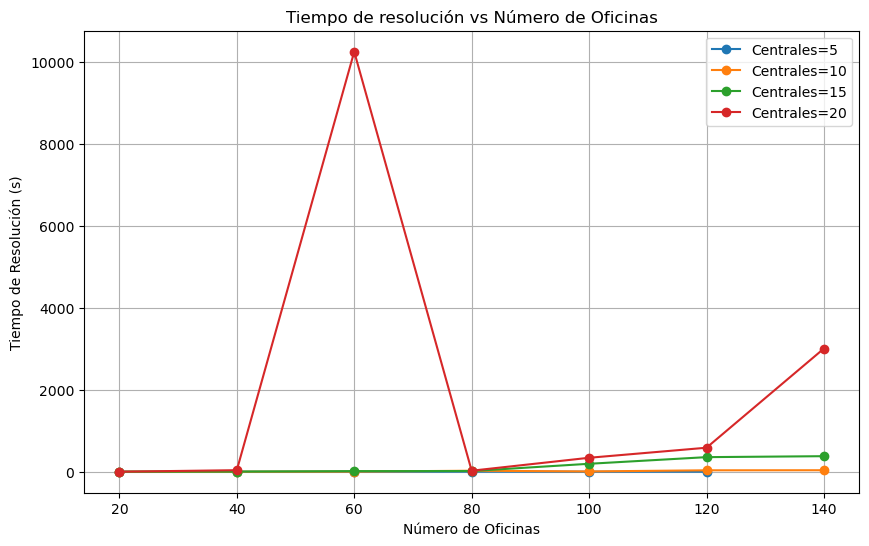

In [2]:
def generar_instancia(n_oficinas, n_centrales, demanda_min=100, demanda_max=1000, dist_min=100, dist_max=5000, seed=None):
    if seed is not None:
        random.seed(seed)  # semilla para reproducibilidad
    
    # Generar demandas
    demandas = [random.randint(demanda_min, demanda_max) for _ in range(n_oficinas)]
    # Generar matriz de distancias
    distancias = [[random.randint(dist_min, dist_max) for _ in range(n_centrales)] for _ in range(n_oficinas)]
    return demandas, distancias


def resolver_instancia(n_oficinas, n_centrales, demandas, distancias, capacidad=15000, costo_central=5700, costo_cable=0.017):
    # Crear solver
    solver = pywraplp.Solver.CreateSolver('SCIP')
    if not solver:
        return None

    # Índices
    I = list(range(n_oficinas))
    J = list(range(n_centrales))

    # Variables
    y = {j: solver.BoolVar(f'y[{j}]') for j in J}
    x = {(i, j): solver.BoolVar(f'x[{i},{j}]') for i in I for j in J}

    # Restricciones
    # Cada oficina debe conectarse a una única central
    for i in I:
        solver.Add(sum(x[i, j] for j in J) == 1)

    # La capacidad de cada central no debe ser excedida
    for j in J:
        solver.Add(sum(demandas[i] * x[i, j] for i in I) <= capacidad * y[j])

    # Las oficinas solo pueden conectarse a centrales abiertas
    for i in I:
        for j in J:
            solver.Add(x[i, j] <= y[j])

    # Función objetivo
    costo_centrales = solver.Sum(costo_central * y[j] for j in J)
    costo_distancias = solver.Sum(distancias[i][j] * costo_cable * x[i, j] for i in I for j in J)
    solver.Minimize(costo_centrales + costo_distancias)

    # Resolver
    start_time = time.time()
    status = solver.Solve()
    end_time = time.time()

    if status == pywraplp.Solver.OPTIMAL:
        tiempo_resolucion = end_time - start_time
        return tiempo_resolucion, solver.Objective().Value()
    else:
        return None


resultados = []
seed = 2345
for oficina in [20, 40, 60, 80, 100, 120, 140]:
    for central in [5, 10, 15, 20]:
        demandas, distancias = generar_instancia(oficina, central, seed=seed)
        resultado = resolver_instancia(oficina, central, demandas, distancias)
        if resultado:
            tiempo, costo = resultado
            resultados.append((oficina, central, tiempo, costo))
            print(f"Instancia: Oficinas={oficina}, Centrales={central}, Tiempo={tiempo:.4f}s, Costo={costo:.2f}")
        else:
            print(f"Instancia: Oficinas={oficina}, Centrales={central} -> No factible")

# Visualización
resultados_df = pd.DataFrame(resultados, columns=["Oficinas", "Centrales", "Tiempo", "Costo"])

plt.figure(figsize=(10, 6))
for centrales in resultados_df["Centrales"].unique():
    subset = resultados_df[resultados_df["Centrales"] == centrales]
    plt.plot(subset["Oficinas"], subset["Tiempo"], label=f'Centrales={centrales}', marker='o')

plt.title("Tiempo de resolución vs Número de Oficinas")
plt.xlabel("Número de Oficinas")
plt.ylabel("Tiempo de Resolución (s)")
plt.legend()
plt.grid(True)
plt.show()


Observaciones:

- Podemos observar que con ∣I∣=6 y ∣J∣=10 el tiempo de ejecución se disparó, por lo cual lo tomamos como un outlier, ya que difiere tanto de los otros resultado.

- Relación entre el número de oficinas y el tiempo de resolución:

    A medida que el número de oficinas aumenta ($|I|$), el tiempo de resolución tiende a incrementarse. Esto ocurre porque hay más combinaciones posibles de asignaciones de oficinas a centrales, lo que incrementa el espacio de búsqueda del solver.

    Ejemplo:
    
        - ∣I∣=20, ∣J∣=10: Tiempo = 0.0229 segundos.
        - ∣I∣=40, ∣J∣=10: Tiempo = 0.3228 segundos.
        - ∣I∣=60, ∣J∣=10: Tiempo = 3.2147 segundos.

- Relación entre el número de centrales y el tiempo de resolución:

    Para un número fijo de oficinas, al aumentar el número de centrales ($∣J∣$), el tiempo de resolución también incrementa. Esto ocurre porque hay más opciones posibles para asignar oficinas a centrales.

    Ejemplo:

        - ∣I∣=60, ∣J∣=5: Tiempo = 0.1554 segundos.
        - ∣I∣=60, ∣J∣=10: Tiempo = 3.2147 segundos.
        - ∣I∣=60, ∣J∣=15: Tiempo = 14.4902 segundos.

- Relación entre los costos y el número de centrales:

    Los costos totales tienden a disminuir al aumentar el número de centrales (∣J∣), ya que esto permite una mayor flexibilidad para asignar oficinas a centrales más cercanas, reduciendo el costo de conexión.

    Ejemplo:

        - ∣I∣=20, ∣J∣=5: Costo = 6443.07.
        - ∣I∣=20, ∣J∣=20: Costo = 6304.01.

- No factibilidad:

    Cuando $∣I∣=140$ y $∣J∣=5$, la instancia es no factible. Esto se debe a que las 5 centrales no pueden cubrir la demanda total de las 140 oficinas (el total de la demanda supera la capacidad combinada de las 5 centrales).


Tamaño Crítico

- Criterio de tiempo aceptable:

    Si definimos que un tiempo superior a 10 minutos (600 segundos) es inaceptable, podemos observar que:
    
        - Para ∣I∣=60 y ∣J∣=20, el tiempo ya es inaceptable (10242.1890 segundos).
        - Para ∣I∣≥140, incluso con ∣J∣=20, el tiempo sigue siendo muy alto (3004.1589 segundos).

- Tamaño crítico:

    Para que el tiempo de resolución sea razonable:

        - ∣I∣≤100, ∣J∣≤15: Tiempos de resolución están por debajo de 600 segundos.
        - Ejemplo: ∣I∣=100, ∣J∣=15: Tiempo = 193.6607 segundos.
        Sin embargo, al aumentar cualquiera de estos valores, los tiempos crecen rápidamente.


Estrategias para Mitigar el Problema

Si las instancias grandes deben resolverse y el tiempo es un problema lo que se podría hacer es:

Relajación del modelo: Permitir que las variables $x[i,j]$ sean continuas en lugar de binarias, lo que puede reducir significativamente el tiempo de solución, aunque con una pérdida de precisión.

Descomposición del problema: Dividir el conjunto de oficinas en subgrupos y resolver el problema para cada subgrupo por separado.

Ajuste de parámetros del solver: Utilizar configuraciones específicas en el solver (por ejemplo, cortar la búsqueda después de un tiempo límite y aceptar soluciones subóptimas).

Algoritmos heurísticos: Usar aproximaciones como algoritmos de búsqueda local para encontrar soluciones rápidas aunque no necesariamente óptimas.

## Conclusiones
Este análisis permitirá tomar decisiones informadas sobre la selección y configuración de las centrales operativas y la conexión de las oficinas, optimizando tanto el costo como la eficiencia operativa en el abastecimiento de las oficinas con servicio de Internet.
